In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import ks_2samp
import seaborn as sns

In [2]:
recipes = pd.read_csv("./data/RAW_recipes.csv")
interactions = pd.read_csv("./data/RAW_interactions.csv")
# Subsetting the data to a little more than 75% of the original data
recipes = recipes[pd.to_datetime(recipes["submitted"]).dt.year >= 2008]
interactions = interactions[pd.to_datetime(interactions["date"]).dt.year >= 2008]

# Cleaning data and discussion on what data to give students
As discussed, it may be a good idea to subset the data before giving it to the students however this has the draw back of removing some of the processing steps for the students and not letting them get the data on their own from the kaggle website. With that in mind, here are some possible ways to give them the data to consider:
1. Don't subset the data and make them do all of the processing from the raw data
    - Pros: Maintains the standard of the other projects wherein the students have to get the data from the original souce and process it thems selves.
    - Cons: The RAW_recipes and RAW_interactions datasets are combined half a gig of data that when merged will be very hard to perform permutation tests on. Furthermore, we would have to inform students that they would have to merge the dataset and produce an average rating column after replacing all 0 ratings with nan (refer to code cell below) which may be too much preprocessing to describe and students could make mistakes on.
    
1. We subset the both raw datasets (only include data from 2008 and later) and make them do all of the processing from the raw data
    - Pros: Makes students only work on a little less than 25% of the original dataset which would make merging and other operations much faster. 
    - Cons: We would provide students with pre-processed data which breaks the standard of the other projects (not necessarily a bad thing). Students will still have to be given information that they will have to merge the two datasets and produce an average ratings column after replacing all 0 ratings with nan (this replacing step can be done by us however if we are subsetting the data anyway).
    
1. We subset the both raw datasets and create the average ratings column for them (this is the one we used for this POC)
    - Pros: Same pros as above but also we avoid the situation where students will mess up in the merging process which would effect their analysis
    - Cons: Some of the difficulty of the dataset is removed which we may want students to get experience with and we would be performing extra preprocessing which would further breaks the standard of the other projects (once again, not necessarily a bad thing).

In [3]:
# Merged data
merged_df = recipes.merge(interactions,left_on="id",right_on="recipe_id",how="left")
# Create average rating
subset_merged = merged_df[["id","rating"]]
subset_merged.loc[subset_merged["rating"] == 0,"rating"] = np.nan
ratings = subset_merged.groupby("id")["rating"].mean()
recipes = recipes.merge(ratings,on="id")
# the Dataframe stored in recipes is what we would give students

In [4]:
# Cleaning
recipes["tags"] = recipes["tags"].str.replace("\[|\]","",regex=True).str.split(",") 
recipes["steps"] = recipes["steps"].str.replace("\[|\]","",regex=True).str.split(",") 
recipes["ingredients"] = recipes["ingredients"].str.replace("\[|\]","",regex=True).str.split(",")
recipes["submitted"] = pd.to_datetime(recipes["submitted"])

raw_recipes = recipes
# (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat (PDV) , and carbohydrates (PDV))
# break up nutrition into different measurements
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] = raw_recipes['nutrition'].str.replace("\[|\]","",regex=True).str.split(",",expand=True) 
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] =  raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].astype(float)


# Visualization examples

[Text(0.5, 1.0, 'Distribution of calories')]

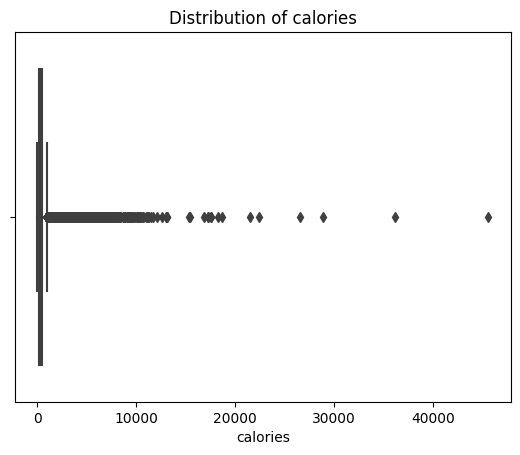

In [5]:
sns.boxplot(x=raw_recipes["calories"]).set(title='Distribution of calories')

[Text(0.5, 1.0, 'Distribution of calories less than 2000')]

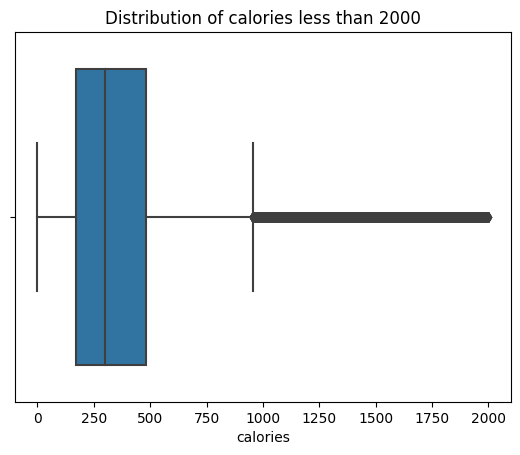

In [6]:
sns.boxplot(x = raw_recipes[raw_recipes["calories"]<=2000]['calories']).set(title='Distribution of calories less than 2000')

In [7]:
# sns.lineplot(data=raw_recipes, x=raw_recipes[raw_recipes["calories"]<=1000]['calories'], y="rating").set(title='relationship between colories and rating')

[Text(0.5, 1.0, 'Distribution of numer of steps')]

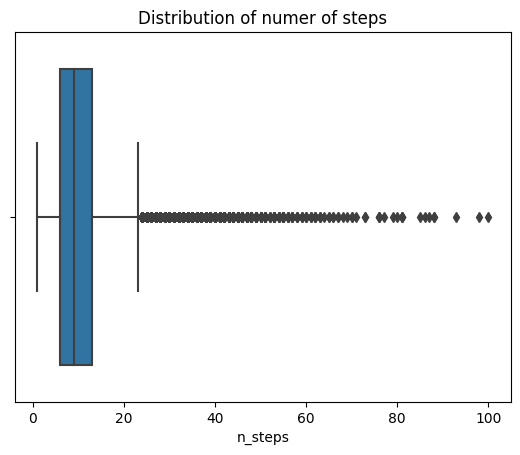

In [8]:
sns.boxplot(x=raw_recipes["n_steps"]).set(title='Distribution of numer of steps')

[Text(0.5, 1.0, 'relationship between number of steps and rating')]

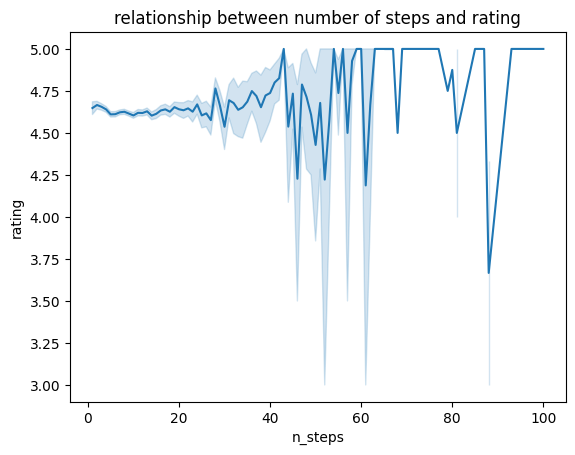

In [9]:
sns.lineplot(data=raw_recipes, x="n_steps", y='rating').set(title='relationship between number of steps and rating')

[Text(0.5, 1.0, 'relationship between carbohydrates and calories')]

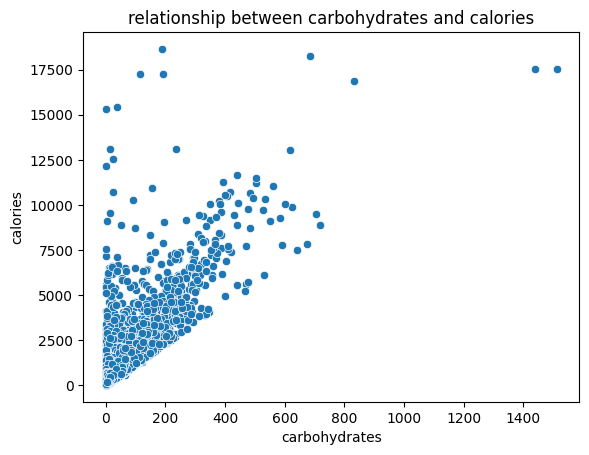

In [10]:
sns.scatterplot(data=raw_recipes, x=raw_recipes['carbohydrates'], y=raw_recipes[raw_recipes['calories']<=20000]['calories']).set(title='relationship between carbohydrates and calories')

[Text(0.5, 1.0, 'relationship between carbohydrates and sodium')]

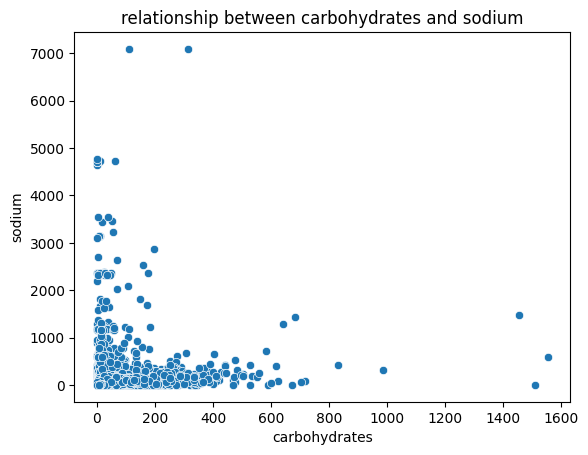

In [11]:
sns.scatterplot(data=raw_recipes, x=raw_recipes[raw_recipes['carbohydrates']<2000]['carbohydrates'], y=raw_recipes[raw_recipes['sodium']<10000]['sodium']).set(title='relationship between carbohydrates and sodium')

# Missingness Evaluation examples

In [12]:
raw_recipes.isna().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description         70
ingredients          0
n_ingredients        0
rating            2609
calories             0
total fat            0
sugar                0
sodium               0
protein              0
saturated fat        0
carbohydrates        0
dtype: int64

In [13]:
def assess_missingness(data,focus_col,compare_col,stat="tvd",n_repetitions=1000):
    def tvd(data,missing_col,compare_col):
        pivoted = (
            shuffled
            .pivot_table(index=missing_col, columns=compare_col, aggfunc='size')
            .apply(lambda x: x / x.sum(), axis=1)
        )

        tvd = pivoted.diff().iloc[-1].abs().sum() / 2
        return tvd
    
    def ks_test(data,missing_col,compare_col):
        missing_data = data.loc[data[missing_col],compare_col]
        nonmissing_data = data.loc[~data[missing_col],compare_col]
        return ks_2samp(missing_data, nonmissing_data).pvalue
    
    shuffled = data.copy()
    missing_col = focus_col+'_missing'
    shuffled[missing_col] = shuffled[focus_col].isna()
    
    
    if stat == "ks":
        return ks_test(shuffled,missing_col,compare_col)
    
    if stat == "tvd":
        obs_tvd = tvd(data,missing_col,compare_col)
        tvds = []
        for _ in tqdm(range(n_repetitions)):

            # Shuffling genders and assigning back to the DataFrame
            shuffled[compare_col] = np.random.permutation(shuffled[compare_col])
            tvds.append(tvd(shuffled,missing_col,compare_col))
        pval = np.mean(np.array(tvds) >= obs_tvd)
        return pval

Looking at the output of the code cell below, there is one instance where the missingness is dependent on another column and one where it is not.

In [14]:
for col in raw_recipes.columns[1:]:
    if col != "rating" or col != "description":
        if raw_recipes[col].dtype == int or raw_recipes[col].dtype == float:
            print(f"Is missingness of rating dependent on {col} (p-value): " + str(assess_missingness(raw_recipes,"rating",col,stat="ks")))
            print(f"Is missingness of description dependent on {col} (p-value): " + str(assess_missingness(raw_recipes,"description",col,stat="ks")))
            

Is missingness of rating dependent on id (p-value): 1.6464784465830318e-33
Is missingness of description dependent on id (p-value): 0.003676562654032711
Is missingness of rating dependent on minutes (p-value): 8.756202351967888e-29
Is missingness of description dependent on minutes (p-value): 0.6849884902717648
Is missingness of rating dependent on contributor_id (p-value): 5.889953194437729e-26
Is missingness of description dependent on contributor_id (p-value): 4.255234091584208e-20
Is missingness of rating dependent on n_steps (p-value): 3.813369074131651e-13
Is missingness of description dependent on n_steps (p-value): 0.14863826683368317
Is missingness of rating dependent on n_ingredients (p-value): 0.112321477466234
Is missingness of description dependent on n_ingredients (p-value): 0.02285803139714456
Is missingness of rating dependent on rating (p-value): 0.0
Is missingness of description dependent on rating (p-value): 0.9770334374362631
Is missingness of rating dependent on ca

# Hypothesis test/ permutation test Example
###### H0: The rating for foods with more than 4 steps and the rating for foods with less than 4 steps have the same distribution, and the observed differences in our samples are due to random chance.
###### H1:  The rating for foods with more than 4 steps are higher than the rating for foods with less than 4 steps on average. The observed difference in our samples cannot be explained by random chance alone.
##### We will be using the significant level alpha = 0.05.

In [15]:
observed_difference = raw_recipes[raw_recipes["n_steps"]<4]['rating'].mean() - raw_recipes[raw_recipes["n_steps"]>=4]['rating'].mean()
observed_difference

0.036042756712419965

In [16]:
n_repetitions = 1000

differences = []
for i in range(n_repetitions):
    
    # Step 1: Shuffle the weights and store them in a DataFrame.
    with_shuffled = raw_recipes.assign(Shuffled_rating=np.random.permutation(raw_recipes['rating']))

    # Step 2: Compute the test statistic.
    # Remember, alphabetically, False comes before True,
    # so this computes True - False.
    
    difference = with_shuffled[with_shuffled["n_steps"]<4]['Shuffled_rating'].mean() - with_shuffled[with_shuffled["n_steps"]>=4]['Shuffled_rating'].mean()
    
    # Step 4: Store the result
    differences.append(difference)
    
differences[:10]

[-0.001227415237035956,
 0.0030063222318226224,
 0.005475469305693537,
 -0.002937051878301844,
 0.008877726557986243,
 -0.017408116670507567,
 0.003964475701396353,
 -0.00564540438336536,
 0.009911987586980864,
 -0.0013977092526751278]

In [17]:
(np.array(differences) >= observed_difference).mean()

0.0

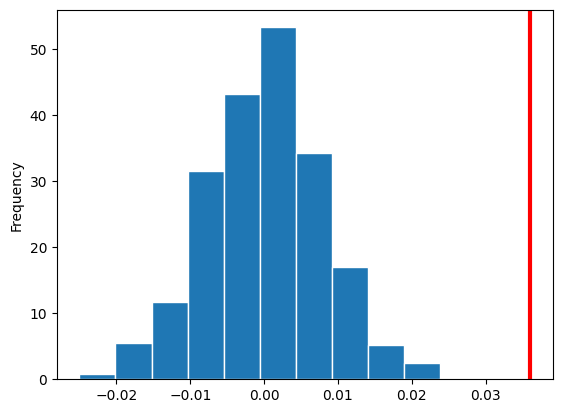

In [18]:
import matplotlib.pyplot as plt
pd.Series(differences).plot(kind='hist', density=True, ec='w', bins=10)
plt.axvline(x=observed_difference, color='red', linewidth=3)

Conclusion: The p-value is 0.0, which is less than 0.05.
Hence we reject the null hypothesis, we cannot conclude that foods with more than 4 steps and the rating for foods with less than 4 steps come from the same distribution..